# 4. Score-Based Generative Models (Noise Conditional Score Network)

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import math

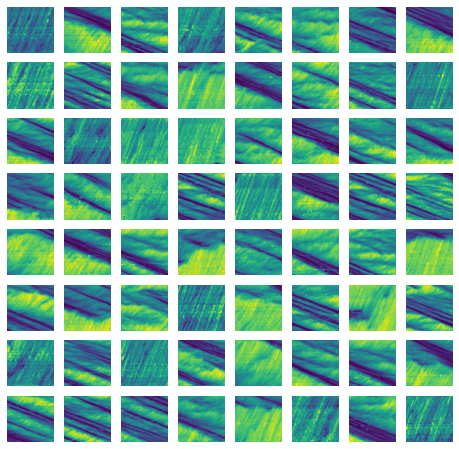

In [2]:
data = np.load('dataset/i24speedcontour_64.npy')
data = torch.tensor(data, dtype=torch.float32)
data = data.permute(0, 1, 3, 2)
data[data > 145] = 145

data_min = data.min()
data_max = data.max()

data = (data - data_min) / (data_max - data_min)

fig, ax = plt.subplots(8, 8, figsize=(8, 8))
for i in range(8):
    for j in range(8):
        ax[i, j].imshow(data[np.random.randint(data.shape[0])][0], origin="lower" )
        ax[i, j].axis("off")

In [3]:
# Split the data into training and validation sets
train_size = int(0.8 * len(data))
val_size = len(data) - train_size

train_data, val_data = torch.utils.data.random_split(data, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)

![alt text](img/Score_based_Generative_Model_edit.png "Title")

In [4]:
# Conditional Batch Normalization
class ConditionalBatchNorm2d(nn.Module):
    def __init__(self, num_features, n_steps):
        super().__init__()
        self.num_features = num_features
        self.bn = nn.BatchNorm2d(num_features)
        self.embed = nn.Embedding(n_steps, num_features * 2)
        
        self.embed.weight.data[:, :num_features].uniform_()
        self.embed.weight.data[:, num_features:].zero_()
            
    def forward(self, x, y):
        out = self.bn(x)
        gamma, beta = self.embed(y).chunk(2, dim=1)
        out = gamma.view(-1, self.num_features, 1, 1) * out + beta.view(-1, self.num_features, 1, 1)
        return out

# Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, n_steps, dilation=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=dilation, dilation=dilation)
        self.norm1 = ConditionalBatchNorm2d(out_channels, n_steps)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=dilation, dilation=dilation)
        self.norm2 = ConditionalBatchNorm2d(out_channels, n_steps)
        self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1) if in_channels != out_channels else nn.Identity()
        self.act = nn.ELU()

    def forward(self, x, y):
        out = self.act(self.norm1(self.conv1(x), y))
        out = self.norm2(self.conv2(out), y)
        out += self.shortcut(x)
        return self.act(out)

# Refinement Network
class CondRefineNetDilated(nn.Module):
    def __init__(self, n_steps):
        super().__init__()
        self.n_steps = n_steps
        self.num_filter = 64
        
        self.begin_conv = nn.Conv2d(4, self.num_filter, kernel_size=3, padding=1)
        self.end_conv = nn.Conv2d(self.num_filter*2, 4, kernel_size=3, padding=1)
        self.act = nn.ELU()

        self.res1 = ResidualBlock(self.num_filter, self.num_filter, n_steps)
        self.res2 = ResidualBlock(self.num_filter, 2 * self.num_filter, n_steps, dilation=2)
        self.res3 = ResidualBlock(2 * self.num_filter, 2 * self.num_filter, n_steps, dilation=4)

    def forward(self, x, y):
        out = self.act(self.begin_conv(x))
        out = self.res1(out, y)
        out = self.res2(out, y)
        out = self.res3(out, y)
        out = self.act(out)
        out = self.end_conv(out)
        return out

The objective function of Score-based Model can be defined as

- $\mathbb{E}_{\mathbf{x} \sim p(\mathbf{x})} \left[\mathbb{E}_{\tilde{\mathbf{x}} \sim q_\sigma \left( \tilde{\mathbf{x}} | \mathbf{x} \right)} \left|\left|{ \nabla_{\mathbf{x}} \log q_\sigma \left( \tilde{\mathbf{x}} | \mathbf{x} \right) - s_{\theta} (\tilde{\mathbf{x}} , \sigma)}^2 \right|\right| _2 \right] $

<br/>
<br/>

We are using the normal distribution for the noise. Therefore

- $q_\sigma \left( \tilde{\mathbf{x}} | \mathbf{x} \right) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp \left(-\frac{\left(\tilde{\mathbf{x}}-\mathbf{x} \right)^2}{2 \sigma^2}\right)$

- $\log q_\sigma \left( \tilde{\mathbf{x}} | \mathbf{x} \right) = -\frac{\left(\tilde{\mathbf{x}}-\mathbf{x}\right)^2}{2 \sigma^2}-\log \left(\sqrt{2 \pi \sigma^2}\right)$

- $\nabla_{\mathbf{x}} \log q_\sigma \left( \tilde{\mathbf{x}} | \mathbf{x} \right) = -\frac{\left(\tilde{\mathbf{x}}-\mathbf{x}\right)}{\sigma^2}$

<br/>
<br/>

By definition, $\tilde{\mathbf{x}}$ is defined as $\tilde{\mathbf{x}}=\mathbf{x}+\sigma \cdot \epsilon$. Then $\nabla_{\mathbf{x}} \log q_\sigma \left( \tilde{\mathbf{x}} | \mathbf{x} \right)$ is transformed as

- $ \begin{align} \nabla_{\mathbf{x}} \log q_\sigma \left( \tilde{\mathbf{x}} | \mathbf{x} \right) &= -\frac{\left(\tilde{\mathbf{x}}-\mathbf{x}\right)}{\sigma^2} \\ &= -\frac{\left(\mathbf{x}+\sigma \cdot \epsilon-\mathbf{x}\right)}{\sigma^2}\\ &= -\frac{\epsilon}{\sigma}\\ \end{align} $

<br/>
<br/>

Practically, $\sigma^2$ is multiplied to the objective function as the weight.

In [5]:
class Model(nn.Module):
    def __init__(self, n_steps, sigma_min, sigma_max):
        super().__init__()
        self.sigmas = torch.exp(torch.linspace(start=math.log(sigma_max), end=math.log(sigma_min), steps = n_steps))
        self.conv_layer = CondRefineNetDilated(n_steps)

    def loss_fn(self, x, idx=None):
        '''
        This function performed when only training phase.

        '''
        scores, target, sigma = self.forward(x, idx=idx, get_target=True)
        target = target.view(target.shape[0], -1)
        scores = scores.view(scores.shape[0], -1)        
        losses = torch.square(scores - target).mean(dim=-1) * sigma.squeeze() ** 2
        return losses.mean(dim=0)

    def forward(self, x, idx=None, get_target=False):
        '''
        x          : real data if idx==None else perturbation data
        idx        : if None (training phase), we perturbed random index. Else (inference phase), it is recommended that you specify.
        get_target : if True (training phase), target and sigma is returned with output (score prediction)

        '''

        if idx == None:
            idx = torch.randint(0, len(self.sigmas), (x.size(0), 1))

            used_sigmas = self.sigmas[idx][:, :, None, None].to(device)
            noise = torch.randn_like(x)
            x_tilde = x + noise * used_sigmas
            idx = idx.squeeze()
        else:
            idx = torch.Tensor([idx for _ in range(x.size(0))]).long()
            x_tilde = x
            
        if get_target:
            target = - 1 / (used_sigmas ) * noise 

            
        output = self.conv_layer(x_tilde, idx.to(device))

        return (output, target, used_sigmas) if get_target else output

The sample is generated by Annealed Langevin Dynamics.

- $\mathbf{x}_{i+1} \leftarrow \mathbf{x}_{i} +  s_{\theta} (\mathbf{x}_i) \cdot \epsilon + \sqrt{2\epsilon} \cdot \mathbf{z}_i$

In [6]:
class AnnealedLangevinDynamic():
    def __init__(self, sigma_min, sigma_max, n_steps, annealed_step, score_fn, device, eps = 1e-1):

        self.process = torch.exp(torch.linspace(start=math.log(sigma_max), end=math.log(sigma_min), steps = n_steps))
        self.step_size = eps * (self.process / self.process[-1] ) ** 2
        self.score_fn = score_fn
        self.annealed_step = annealed_step
        
    # One iteration of annealed step
    def _one_annealed_step_iteration(self, x, idx):
        '''
        x   : perturbated data
        idx : step of perturbation schedule
        '''
        self.score_fn.eval()
        z, step_size = torch.randn_like(x), self.step_size[idx]

        x = x + 0.5 * step_size * self.score_fn(x, idx) + torch.sqrt(step_size) * z
        return x

    def _one_annealed_step(self, x, idx):
        
        for _ in range(self.annealed_step):
            x = self._one_annealed_step_iteration(x, idx)
        return x
        
    # One Langevin Step
    def _one_diffusion_step(self, x):
        '''
        x   : sampling of prior distribution
        '''
        for idx in range(len(self.process)):
            x = self._one_annealed_step(x, idx)
            yield x

    @torch.no_grad()
    def sampling(self, sampling_number, only_final=False):

        sample = torch.rand([sampling_number, 4, 64, 64]).to(device)
        sampling_list = []
        
        final = None
        for sample in self._one_diffusion_step(sample):
            final = sample
            if not only_final:
                sampling_list.append(final)
                

        return final if only_final else torch.stack(sampling_list)

In [16]:
# epsilon of step size
eps = 1e-4

# sigma min and max of Langevin dynamic
sigma_min = 0.05
sigma_max = 1.5

# Langevin step size and Annealed size
n_steps = 25
annealed_step = 200

# Initialize model
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
score_fn = Model(n_steps, sigma_min, sigma_max).to(device)
dynamic = AnnealedLangevinDynamic(sigma_min, sigma_max, n_steps, annealed_step, score_fn, device, eps=eps)

# Optimizer
optim = torch.optim.Adam(score_fn.parameters(), lr = 0.0015)

In [17]:
num_epochs = 20

for epoch in range(num_epochs):
    running_loss = 0.0
    for data in train_loader:
        optim.zero_grad()
        data = data.to(device)
        batch_size = data.size(0)
        
        loss = score_fn.loss_fn(data)
        
        loss.backward()
        optim.step()
        
        running_loss += loss*batch_size
    
    avg_loss = running_loss / train_size
    print(f'Epoch [{epoch+1:02}/{num_epochs}] Loss: {avg_loss:>6.4f}')

# Save the model after training
torch.save(score_fn.state_dict(), 'models/score_fn.pth')
print("Score Network models saved.")

Epoch [01/20] Loss: 0.4267
Epoch [02/20] Loss: 0.1469
Epoch [03/20] Loss: 0.0882
Epoch [04/20] Loss: 0.0751
Epoch [05/20] Loss: 0.0693
Epoch [06/20] Loss: 0.0651
Epoch [07/20] Loss: 0.0618
Epoch [08/20] Loss: 0.0609
Epoch [09/20] Loss: 0.0582
Epoch [10/20] Loss: 0.0566
Epoch [11/20] Loss: 0.0558
Epoch [12/20] Loss: 0.0560
Epoch [13/20] Loss: 0.0546
Epoch [14/20] Loss: 0.0543
Epoch [15/20] Loss: 0.0532
Epoch [16/20] Loss: 0.0526
Epoch [17/20] Loss: 0.0530
Epoch [18/20] Loss: 0.0527
Epoch [19/20] Loss: 0.0519
Epoch [20/20] Loss: 0.0509
Score Network models saved.


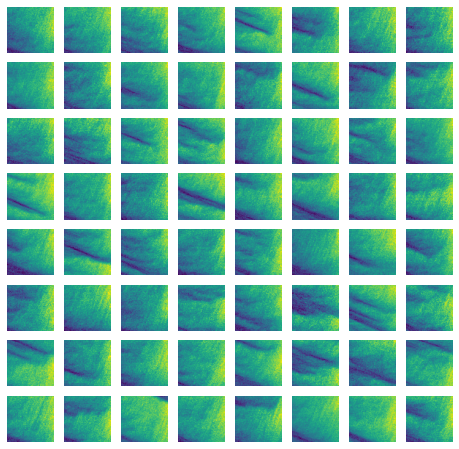

In [19]:
sampling_number = 64
# Suggest to use GPU. Running Annealed Langevin Dynamics in CPU takes extremely long time
# device = "cpu"

# score_fn = Model(n_steps, sigma_min, sigma_max).to(device)
# score_fn.load_state_dict(torch.load('models/score_fn.pth', map_location=device))
dynamic = AnnealedLangevinDynamic(sigma_min, sigma_max, n_steps, annealed_step, score_fn, device, eps=eps)
sample = dynamic.sampling(sampling_number, only_final=True)

fig, ax = plt.subplots(8, 8, figsize=(8, 8))
for i in range(8):
    for j in rgange(8):
        ax[i, j].imshow(sample.cpu().numpy()[i * 8 + j][0,:,:], origin="lower")
        ax[i, j].axis("off")

plt.savefig("img/NCSN_result.png", dpi=500)
plt.show()